In [1]:
import sys
sys.path.append('..')

In [2]:
from common.utility import show_implementation
from module.utility import show_images

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
woman_image = np.array(Image.open(
    'images/woman.jpg').resize((288, 216)).convert('L'))

button_image = np.array(Image.open(
    'images/buttons.jpg').resize((320, 480)).convert('L'))

In [4]:
shape_image = Image.open('images/shapes.png')
shape_image = np.array(shape_image.convert('L'))

# Key Points
## Motivation

Suppose that, given a set of images that are taken a distance apart in the scene, we wish to join them together to form one big image.
That is, suppose that we are trying to recreate the panorama feature on smart phones.

To do so, we need to do the following for each pair of images to match:
1. Find locations to match
2. Have a representation of the surrounding region
3. Perform the matching

## Characteristics of Good Local Features
* Repeatable interest points
    * The same point can be found in other images, regardless of geometric and photometric transformations
        * Geometric: Rotation/Scale changes
        * Photometric: Intensity changes
* Distinct descriptors
    * Captures distinctively different information for each different points of interest
* Efficient
    * Number of features much be much less than the number of pixels in the image
* Local
    * Feature should occupy a small area of image

### Distinct Descriptors
Consider the the image below.

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


def show_shift(rect=(0, 0, 0, 0), shift=(0, 0, 0, 0), plain=False):
    fig, ax = plt.subplots(figsize=[6.4, 4.8])

    ax.plot((1, 1, 2), (0, 3, 1))
    ax.set_xlim((0, 5))
    ax.set_ylim((0, 5))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if not plain:
        for i, c, loc in zip((1, 4), ("red", "green"), ((2, 4), (1, 3))):
            axins = zoomed_inset_axes(ax, 2, loc=i)

            axins.plot((1, 1, 2), (0, 3, 1))

            x1, x2, y1, y2 = rect

            if i > 1:
                dx, dy = shift
                x1, x2, y1, y2 = x1 + dx, x2 + dx, y1 + dy, y2 + dy

            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins.xaxis.set_visible(False)
            axins.yaxis.set_visible(False)

            mark_inset(ax, axins, loc1=loc[0], loc2=loc[1], edgecolor=c)

            plt.xticks(visible=False)
            plt.yticks(visible=False)
    plt.draw()
    plt.show()

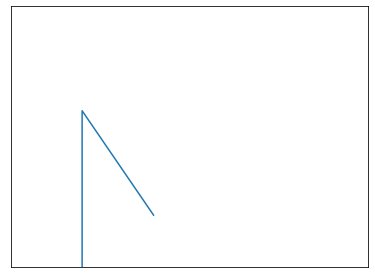

In [6]:
show_shift(plain=True)

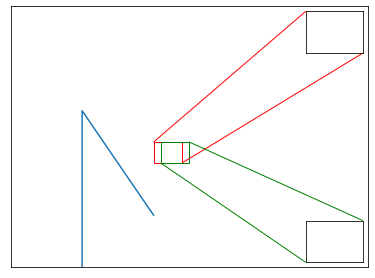

In [7]:
show_shift((2, 2.4, 2, 2.4), (0.1, 0))

Suppose that we are considering the flat region in the image, as above.
Notice that if we shift the window in any direction slightly, the content in the window will not change.
This means this region is **not distinct**.

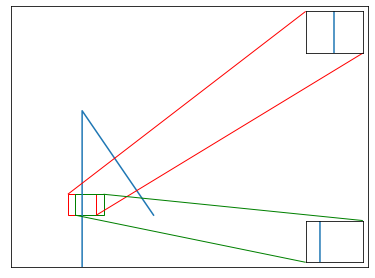

In [8]:
show_shift((0.8, 1.2, 1, 1.4), (0.1, 0))

Now suppose that we instead are considering the region along the vertical line.
Notice that a (small) horizontal shift will change the content in the window, but a (small) vertical shift will not cause any change.

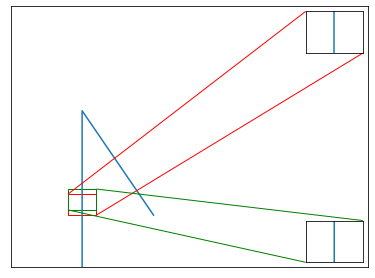

In [9]:
show_shift((0.8, 1.2, 1, 1.4), (0, 0.1))

But notice a (small) vertical shift will not cause any change.

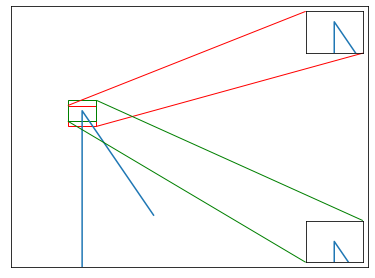

In [10]:
show_shift((0.8, 1.2, 2.7, 3.1), (0, 0.1))

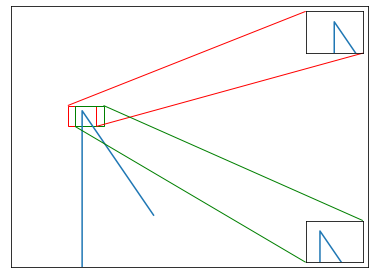

In [11]:
show_shift((0.8, 1.2, 2.7, 3.1), (0.1, 0))

Now consider the window that contains a corner.
Because of this corner, a shift in any direction will change the location of this corner in the window. 
This means that this location is distinct and is what we are looking for.

## How to detect corners?

Suppose we shift a $x \times y$ window $W$ by an offset of $(u, v)$.
To compute the difference of each pixel after shifting, we get:

$$
E(u,v) = \sum _{(x, y) \in W} (I(x+u, y+v) - I(x, y)) ^2
$$

For a good descriptor, we wish for this error to be high.

However, notice that this would require a lot of computation since we would need to compute the difference in windows for each pixel.
Thus, we make some assumptions.

We only consider the cases when the shifts are small.
This allows us to use the following Taylor Series approximation:

$$
I(x+u, y+v) = I(x,y) + \frac{\partial I}{\partial x} u + \frac{\partial I}{\partial y} v + \text {higher order terms} \\
\approx  I(x,y) + \frac{\partial I}{\partial x} u + \frac{\partial I}{\partial y} \\
=  I(x,y) + I_x u + I_y v
$$

Therefore, we get:

$$
E(u,v) = \sum _{(x, y) \in W} (I(x+u, y+v) - I(x, y)) ^2 \\
= \sum _{(x, y) \in W} (I(x,y) + I_x u + I_y v- I(x, y)) ^2
= \sum _{(x, y) \in W} (I_x u + I_y v) ^2\\
= Au^2 + 2Buv + Cv^2\\
\text{where } A = \sum _{(x, y) \in W} I_x^2, \quad B = \sum _{(x, y) \in W} I_x I_y, \quad C = \sum _{(x, y) \in W} I^2_y
$$

We can also write the expression as 

$$E(u,v) = 
\begin{pmatrix}
u & v
\end{pmatrix}
\begin{pmatrix}
A & B \\ B & C
\end{pmatrix}
\begin{pmatrix}
u \\ v
\end{pmatrix}
$$

We call the matrix $H=
\begin{pmatrix}
A & B \\ B & C
\end{pmatrix}$ the second moment matrix

It is known that quadratic functions can be visualized as ellipses.
In this case, $H$ will control the shape of the ellipse, where the eigenvectors of $H$ will control the orientation, and the eigenvalues will control the length of the axes.

You can read up more about eigenvalues/eigenvectors [here](../linear-algebra/eigen.ipynb)

Using the formula there, we know that the eigenvalues for a $2\times2$ matrix $\begin{pmatrix}
a & b \\ c & d
\end{pmatrix}$
is:

$$
\lambda _\pm = \frac{1}{2}\left( a + d \pm \sqrt {4bc + (a - d)^2}\right)
$$

Hence, the larger eigenvalue corresponds to the direction of the largest increase in error, while its eigenvalue correspond to the amount of increase in that direction.
Similarly, the smaller eigenvector corresponds to the smallest increase.

This means that when only one of the eigenvalue is zero, it means that we are in a region along an straight edge.

And if both are zero, we are in the flat region.

### Finding Corners
Thus, it becomes straightforward that we wish to find areas where the smaller eigenvalue is large, as those will correspond to regions which gives large changes in the window regardless of shift direction.

In [12]:
from module.gradient import compute_one_gradient
from module.kernel import Orientation
from module.convolve import convolve


def _ev(a, b, c, d):
    return 0.5 * (a + d - np.sqrt(4 * b * c + (a - d) ** 2)), 0.5 * (a + d + np.sqrt(4 * b * c + (a - d) ** 2))


def eig(image, window_size=5, kappa=0.05, window=None):
    Ix = compute_one_gradient(image, Orientation.horizontal)
    Iy = compute_one_gradient(image, Orientation.vertical)

    w = np.ones((window_size, window_size)) if window is None else window

    A = convolve(Ix**2, w, clip=False, pad=False)
    B = convolve(Ix*Iy, w, clip=False, pad=False)
    C = convolve(Iy**2, w, clip=False, pad=False)

    return _ev(A, B, B, C)


ev1, ev2 = eig(shape_image)

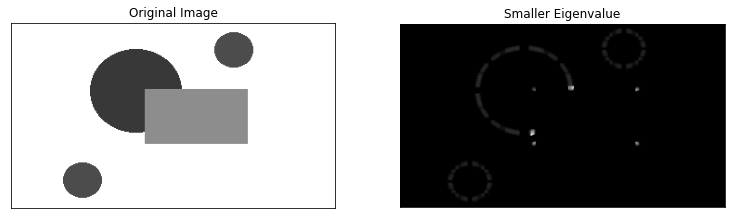

In [13]:
show_images((shape_image, "Original Image"), (ev1, "Smaller Eigenvalue", True))

---
#### Side note

The larger eigenvalue does also gives us some "interesting" results (strikingly similar to an edge detector), as shown below.

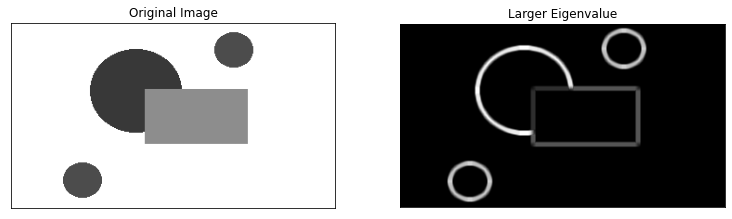

In [14]:
show_images((shape_image, "Original Image"), (ev2, "Larger Eigenvalue", True))

---

With this, we do indeed locate the corners in the image.

However, finding eigenvalue is a slow process, since we need to compute roots.
We can use the following approximation using the **Harris operator**, defined as:

$$
R = \det H - \kappa \text{trace}^2 H
$$

where
$$
\det H = \lambda_1 \lambda_2, \quad \text{trace} H = \lambda_1 + \lambda_2,  \quad 0.04 \leq \kappa \leq 0.06 
$$

By linear algebra, we also know that $\det H = AC - B^2$, and trace $H = A + C$, which speeds up our computation.

In [15]:
from module.keypoints import harris
show_implementation(harris)

def harris(image, window_size=5, kappa=0.05, window=None):
    Ix = compute_one_gradient(image, Orientation.horizontal)
    Iy = compute_one_gradient(image, Orientation.vertical)

    w = np.ones((window_size, window_size)) if window is None else window

    A = convolve(Ix**2, w, clip=False, pad=False)
    B = convolve(Ix*Iy, w, clip=False, pad=False)
    C = convolve(Iy**2, w, clip=False, pad=False)

    det = A * C - B ** 2
    tr = A + C

    R = det - 0.05 * tr ** 2

    return R


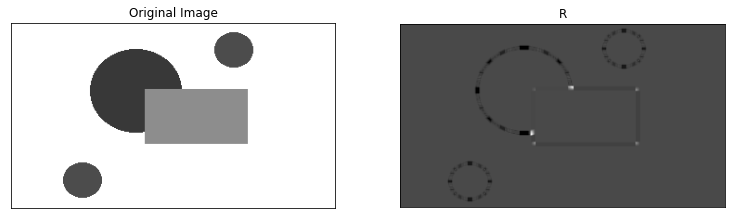

In [16]:
R = harris(shape_image)

show_images((shape_image, "Original Image"), (R, "R", True))

As we can see, we indeed get a high response at the corners of the rectangle.

Usually, to get better effects, we would weight the derivatives based on their distance from the center pixel.
Once again, notice that this simply correspond to filtering with a Gaussian filter, as shown below.

In [17]:
from module.kernel import gaussian_filter
R = harris(shape_image, window=gaussian_filter(5))

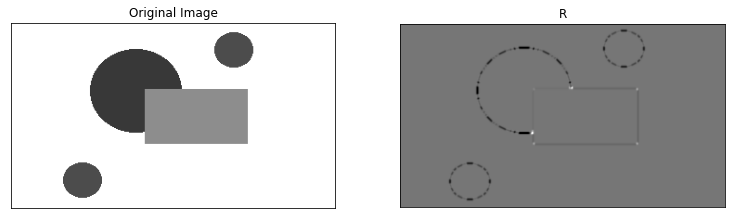

In [18]:
show_images((shape_image, "Original Image"), (R, "R", True))

From the above, we can see that it does identifies the corners rather well.

### Non-Maximum Suppression


Similar to in the [gradients and edges chapter](./gradients_and_edges.ipynb#non-maximum-suppressions), we need to thin down the region identified from our response; as they do no correspond to a singular pixel location, but rather an area of pixels.

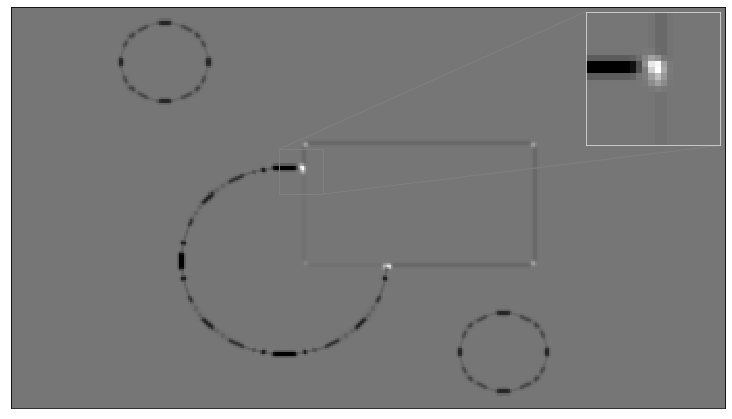

In [19]:
fig, ax = plt.subplots(figsize=[12.8, 9.6])

extent = [0, 8, 0, 4.5]
ax.imshow(R, extent=extent, interpolation="nearest",
          origin="lower", cmap="gray")

axins = zoomed_inset_axes(ax, 3, loc=1)
axins.imshow(R, extent=extent, interpolation="nearest",
             origin="lower", cmap="gray")
axins.face_color = "white"
x1, x2, y1, y2 = 3, 3.5, 2.4, 2.9
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.spines['bottom'].set_color('#dddddd')
axins.spines['top'].set_color('#dddddd')
axins.spines['right'].set_color('#dddddd')
axins.spines['left'].set_color('#dddddd')


axins.yaxis.set_visible(False)
axins.xaxis.set_visible(False)

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.draw()
plt.show()

Thus, we need to perform non-maximum suppression too.

#### Simple non-maximum suppression


A simple approach is to:
1. For each pixel with some response, consider an area around it
2. For each other pixel in the area, find the pixel with the largest response
3. Using the pixel with the largest response as the center, zero out all other pixels within a distance from it.

After that, we can simply select the top-k pixels with the largest response, as they would be the most suitable as key points.

In [20]:
from module.nonmaximum_suppresion import simple_area, top_k
show_implementation(simple_area)
show_implementation(top_k)

def simple_area(image, window_size=11):
    mask = np.full(image.shape, True)

    LEFT = window_size // 2
    RIGHT = window_size - LEFT
    sorted_response_inds = np.flip(image.argsort(axis=None))
    indices = np.unravel_index(sorted_response_inds, image.shape)

    for ind in zip(indices[0], indices[1]):
        if not mask[ind]:
            continue
        left = max(ind[0] - LEFT, 0)
        top = max(ind[1] - LEFT, 0)

        mask[left: ind[0] + RIGHT,
             top: ind[1] + RIGHT] = False
        mask[ind] = True

    return np.argwhere(mask)
def top_k(image, points, k):
    intensities = image[points[:, 0], points[:, 1]]
    return points[np.flip(np.argsort(intensities, axis=0))][:k]


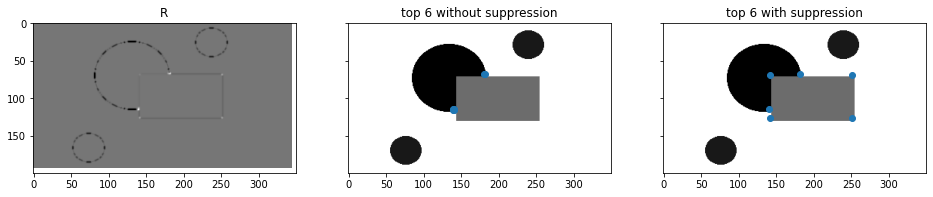

In [21]:
fig = plt.figure(figsize=(16,10))
axs = fig.subplots(1, 3, sharex=True, sharey=True)

axs[0].imshow(R, cmap='gray')
axs[1].imshow(shape_image, cmap='gray')
axs[2].imshow(shape_image, cmap='gray')

k = 6
all_points = np.indices(R.shape).T.reshape(-1, 2)
top6 = top_k(R, all_points, 6)

suppressed = simple_area(R)
top6_s = top_k(R, suppressed, 6)

axs[1].scatter(top6[:,1],top6[:, 0])
axs[2].scatter(top6_s[:,1],top6_s[:, 0])

axs[0].set_title("R")
axs[1].set_title("top 6 without suppression")
axs[2].set_title("top 6 with suppression")
plt.show()

Thus, we can see that the key points are more localized from above.
And the top-k with suppression yields spatially sparse points as we desired.

#### Adaptive non-maximum suppression

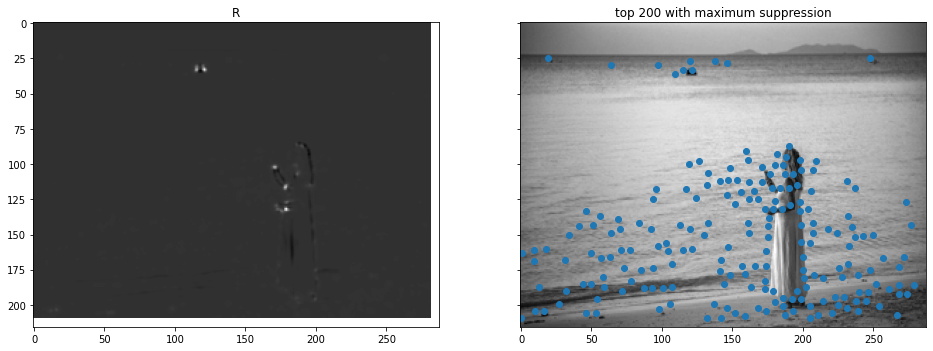

In [22]:
fig = plt.figure(figsize=(16, 10))
axs = fig.subplots(1, 2, sharex=True, sharey=True)

R = harris(woman_image, window=gaussian_filter(5))
suppressed = simple_area(R)
top200 = top_k(R, suppressed, 200)

axs[0].imshow(R, cmap='gray')
axs[1].imshow(woman_image, cmap='gray')

axs[1].scatter(top200[:, 1], top200[:, 0])

axs[0].set_title("R")
axs[1].set_title("top 200 with maximum suppression")
plt.show()

In [23]:
from module.nonmaximum_suppresion import adaptive_area
show_implementation(adaptive_area)

def adaptive_area(image, r):
    ps = simple_area(image)

    tree = KDTree(ps)

    neighbours = tree.query_ball_point(ps, r, workers=-1)

    for i, n in enumerate(neighbours):
        n.remove(i)

    result = []

    for p, n in zip(ps, neighbours):
        if len(n) == 0:
            result.append(p)
            continue

        indices = ps[n]
        largest_n = image[ps[n][:, 0], ps[n][:, 1]].max()

        self = image[p[0], p[1]]
        if self > largest_n:
            result.append(p)

    return np.array(result)


Note that using the simple non-maximum suppression and selecting the top-k strongest response will lead to uneven distribution of key points in places of high contrast, since those regions will produce stronger response.
To remedy this, we can select a local maxima as a key point only if they are significantly greater other local maximas in a certain radius $r$.

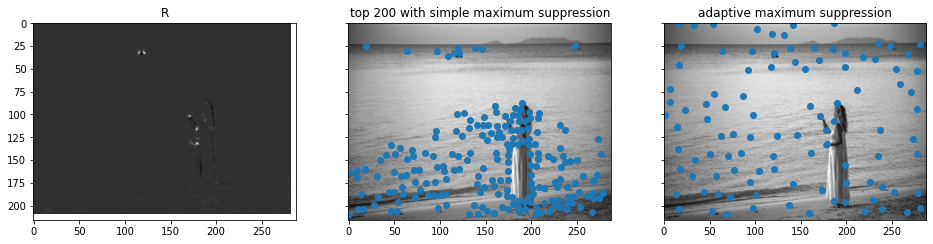

In [24]:
fig = plt.figure(figsize=(16, 10))
axs = fig.subplots(1, 3, sharex=True, sharey=True)

axs[0].imshow(R, cmap='gray')
axs[1].imshow(woman_image, cmap='gray')
axs[2].imshow(woman_image, cmap='gray')

R = harris(woman_image, window=gaussian_filter(5))
suppressed = simple_area(R)
top200 = top_k(R, suppressed, 200)

adaptive = adaptive_area(R, 13)

axs[1].scatter(top200[:, 1], top200[:, 0])
axs[2].scatter(adaptive[:, 1], adaptive[:, 0])

axs[0].set_title("R")
axs[1].set_title("top 200 with simple maximum suppression")
axs[2].set_title("adaptive maximum suppression")
plt.show()

As we can see, we obtain a more evenly spread of key points, as we have more keypoints in the further parts of the water with less contrast.
Compare this with simply non-maximum suppression, where key points are clumped by the shore.

### Properties of Harris corners


#### Definitions

Given a point on an image with a corresponding score, 

**Equivariance**: when an image is transformed (spatially), the point also undergoes a similar transformation

**Invariance**: when an image is transformed, the score does not change

#### Translation
Since H is determined by the derivative of the intensity, it is unaffected by translation.
And since eigenvalues are determined by the derivatives, it means that (with respect to translations) Harris corners are:

* **Equivariant**
* **Invariant**

#### Rotation
Similarly, since eigenvectors rotates with an rotation of the image, and eigenvalues are unaffected by a rotation of the image, Harris corners are:

* **Equivariant**
* **Invariant**

#### Scale

Consider any corner in an image.
Suppose that we zoom it in closer.
At some point, this corner will no longer be an corner (at one extreme, if our window is size 1, it will simply be a pixel and will not be a corner).
Hence, with respect to scaling, Harris corners is:

* **Not equivariant**
* **Not invariant**

#### Photometric transformation
##### Change in brightness
Suppose that we adjust the image intensities to $I' = I + b$.
Notice that since our Harris corners are dependent on the derivatives of the intensities and not the intensities themselves, a constant change to every pixel will not affect the derivatives and thus Harris corners are:

* **Invariant**

##### Change in contrast
Suppose that we adjust the image intensities to $I' = a I$.
This means that our $I'_x = aI_x$ and $I'_y = aI_y$

Equivalently, this means that $H' = a^2H$

Notice that this affects score by a factor, hence Harris corners are:

* **Not Invariant**

## Blob detector
A blob is a region of light pixels on a dark background, or dark pixels on a light background.
Blobs can also be good candidates to use as keypoints.

### Laplacian of Gaussian
One such blob detector is (surprisingly) the [**Laplacian of Gaussian**](./gradients_and_edges.ipynb#log).

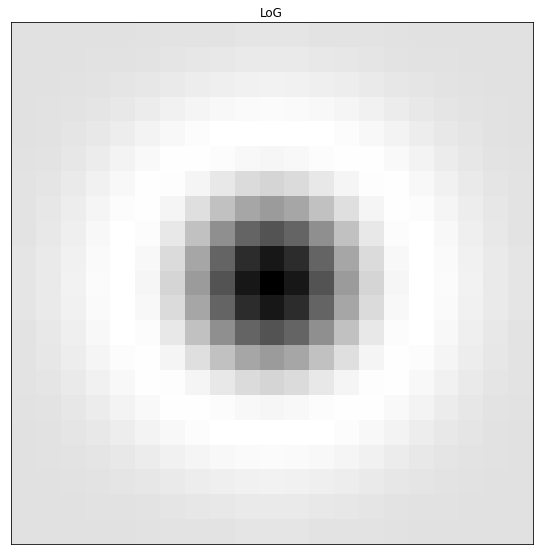

In [25]:
from module.kernel import log

show_images((log(21, sigma=3), "LoG", True))

Note that there is a ring of high intensity pixels after the center blob.
This ring has higher intensity than the edges of the filter.

Notice that because of this characteristics, this filter will obtain the strongest response to regions which contains high intensity everywhere except the center circle region (*ie* a dark blob on a light background).

Because of this property, we can treat LoG filters as a **band-pass filter**

Another way to think about it is that a LoG filter can be approximated by a smaller Gaussian subtracted from a larger Gaussian.

In [26]:
sigmas = [1, 4]

logs = [(convolve(button_image, log(31,  sigma=i), pad=False,
         clip=False), f"LoG sigma={i}", True) for i in sigmas]

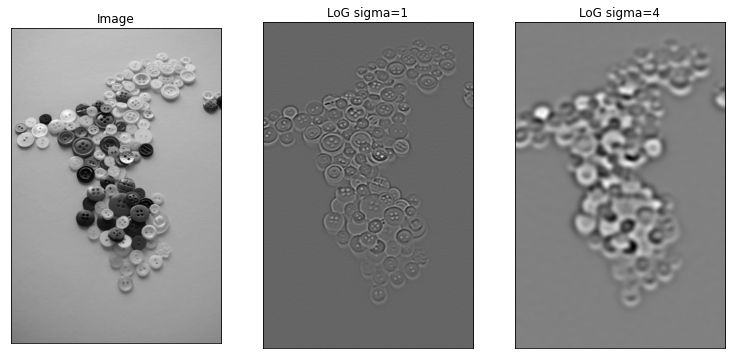

In [27]:
show_images((button_image, "Image"), *logs)

*Photo by Monstera from Pexels*

Notice that when we use a smaller $\sigma$, we get high responses in the "dots of the buttons".
But at higher $\sigma$, we get stronger response at the certain buttons of that size.

Hence, to detect blobs of all sizes in the image, a simple approach is to filter them using LoG filters of different sizes, perform some thresholding and obtaining the key point locations.

However, this is rather inefficient because the kernel can get rather big, which increases the computation needed to determine the blobs.


### Multiscale detection <span id="multiscale-processing"><span>

A way around this is to use the [Gaussian pyramid](./filtering.ipynb#gaussian-pyramid).

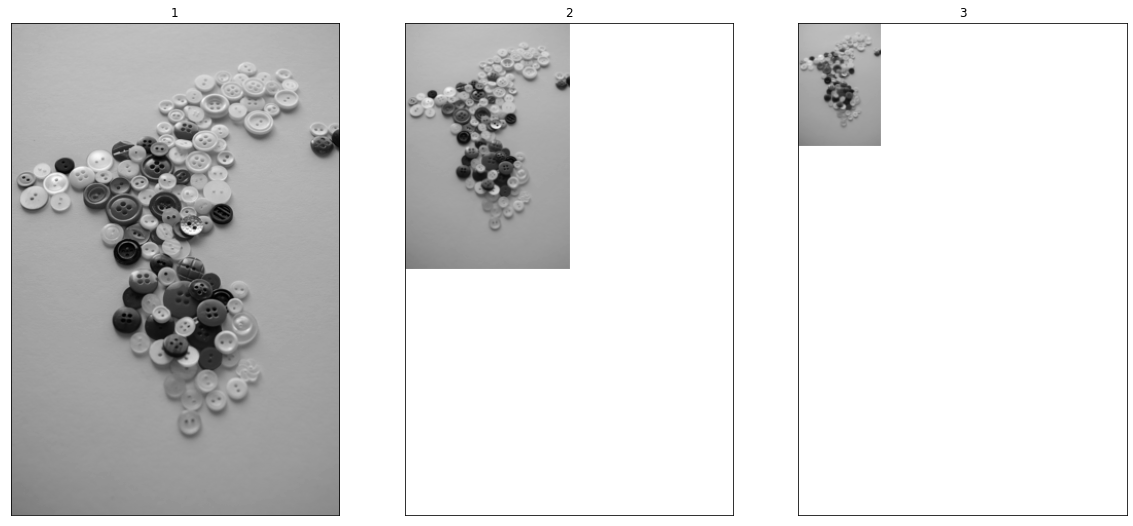

In [28]:
from module.pyramid import make_gaussian_pyramid
from module.utility import show_pyramids

pyramid = make_gaussian_pyramid(button_image, 3)
show_pyramids(pyramid, "{}")

We scale down the the image instead of scaling up the kernel.
We then perform our convolution using a fixed kernel on these images of decreasing size.
Since the relative size of kernel to image is the same as our previous approach, we would have similar results, except that the convolution is much faster because the kernel size is not increasing.

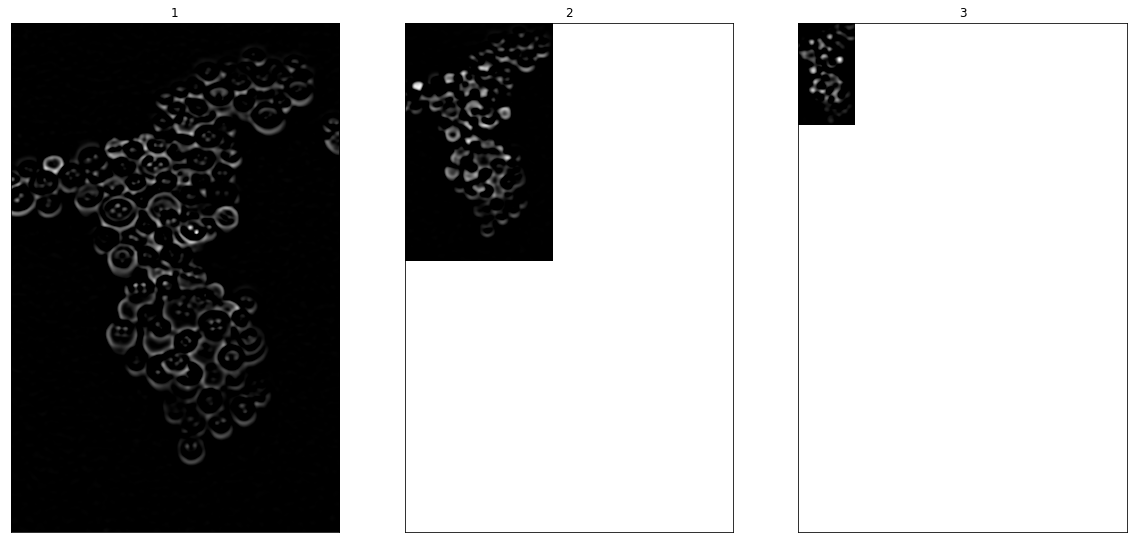

In [29]:
from module.pyramid import make_gaussian_pyramid
from module.utility import show_pyramids

convolved = [convolve(im, log(31, sigma=2), pad=False, clip=False)
             for im in pyramid]

show_pyramids(convolved, "{}", autoscale=True)

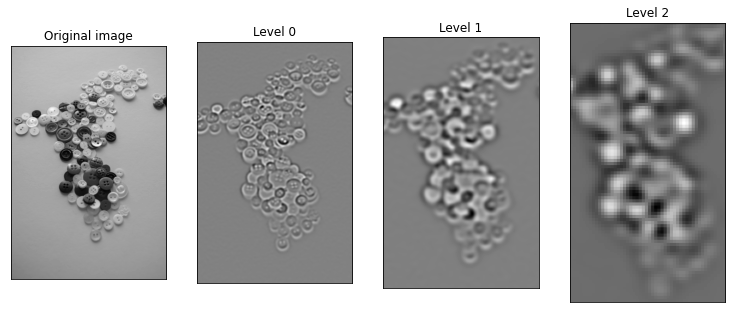

In [30]:
stretched = [np.repeat(np.repeat(img, 2**i, axis=0), 2**i, axis=1)
             for i, img in enumerate(convolved)]

show_images((button_image, "Original image"), *[(s, f"Level {i}", True) for i, s in enumerate(stretched)])

Notice that as we work with smaller images, larger blobs gives a stronger response.